<a href="https://colab.research.google.com/github/makemebright/Machine-Learning/blob/main/ML_pet_proj2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### Тема: Основы работы с искусственными нейронными сетями



### Выполнил: <font color='red'>Иконников Марк Игоревич, МФТИ, ФПМИ Б05-206в</font>




Для выполнения задания загрузим набор данных для задачи multi-label классификации текстов EURLex (только английскую часть) следующим кодом:

In [ ]:
from datasets import load_dataset
dataset = load_dataset('multi_eurlex', 'en')

C:\Users\mrkik\anaconda3\envs\tf-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Reusing dataset multi_eurlex (C:\Users\mrkik\.cache\huggingface\datasets\multi_eurlex\en\1.0.0\8ec8b79877a517369a143ead6679d1788d13e51cf641ed29772f4449e8364fb6)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 16.32it/s]


Самый простой способ выучить модель классификации - использовать лог-регрессию на сжатых плотных векторах документов. Для этого нужно выполнить ряд подзадач.

Преобразовать данные в векторный вид с помощью `CountVectorizer` и `TruncatedSVD`:

In [ ]:
!python -V

Python 3.9.18


In [ ]:
!python3 --version

Python 3.10.11


In [ ]:
import sys
sys.executable

'C:\\Users\\mrkik\\anaconda3\\envs\\tf-gpu\\python.exe'

In [ ]:
import torch
import torch.nn as nn
torch.cuda.is_available()

True

In [ ]:
import numpy
numpy.version.version

'1.20.3'

In [ ]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

Преобразуем данные в сжатые эмбеддинги размерности 100

In [ ]:
%%time

texts_train = dataset['train']['text']
texts_valid = dataset['validation']['text']
texts_test = dataset['test']['text']

vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(texts_train)
X_valid_counts = vectorizer.transform(texts_valid)
X_test_counts = vectorizer.transform(texts_test)

svd = TruncatedSVD(n_components=100)
X_train = svd.fit_transform(X_train_counts)
X_valid = svd.transform(X_valid_counts)
X_test = svd.transform(X_test_counts)

CPU times: total: 55.5 s
Wall time: 59.1 s


Конвертируем метки классов в вид бинарной матрицы с размером "число объектов" на "число классов":

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
%%time
# your code here

mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(dataset['train']['labels'])
y_valid = mlb.transform(dataset['validation']['labels'])
y_test = mlb.transform(dataset['test']['labels'])

CPU times: total: 93.8 ms
Wall time: 262 ms


Обучим мета-модель на основе лог-регрессии с помощью `MultiOutputClassifier`:

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [ ]:
%%time
logreg = LogisticRegression(solver='lbfgs', C=0.5, max_iter=1000)
model = MultiOutputClassifier(logreg)
model.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.0398


Опишем функцию подбора оптимальных порогов бинаризации для каждого класса и подберем их для модели на валидационной выборке:

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

Тут позиционный аргумент average не используется, потому что метрика f1_score вызывается по одному классу за раз внутри цикла

In [ ]:
def calculate_best_thresholds(model, X_valid, y_valid, average='macro', step=0.1):
    proba = model.predict_proba(X_valid)
    proba = np.array([p[:, 1] for p in proba]).T  # (n_samples, n_classes)

    best_thresholds = []
    for i in range(proba.shape[1]):
        best_f1 = 0
        best_t = 0.5
        for t in np.arange(0, 1.01, step):
            preds = (proba[:, i] >= t).astype(int)
            f1 = f1_score(y_valid[:, i], preds, average='binary', zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_t = t
        best_thresholds.append(best_t)
    return np.array(best_thresholds)

Опишем код применения модели и порогов к выходным вероятностям для получения значений F1-меры с micro и macro усреднениями и вычислим их на тестовой выборке.

In [ ]:
%%time

best_thresholds = calculate_best_thresholds(model, X_valid, y_valid)

# Предсказание на тесте
proba_test = model.predict_proba(X_test)
proba_test = np.array([p[:, 1] for p in proba_test]).T  # (n_samples, n_classes)

# Применяем пороги
y_test_pred = (proba_test >= best_thresholds).astype(int)

# Оценка качества
print(f"F1-macro: {f1_score(y_test, y_test_pred, average='macro'):.2f}")
print(f"F1-micro: {f1_score(y_test, y_test_pred, average='micro'):.2f}")

F1-macro: 0.49
F1-micro: 0.51
CPU times: total: 688 ms
Wall time: 1 s


Теперь проведем набор запусков с различными комбинациями размера словаря `CountVectorizer` и числа компонент в `TruncatedSVD` и оценим их влияние на качество на текстовой выборке

- попробуем 3 существенно различных значения для каждого параметра
- результаты представим в виде таблиц и сделанных на их основе выводов

In [ ]:
from tqdm import tqdm

In [ ]:
%%time

results = []

max_features_list = [1000, 5000, 10000]
n_components_list = [50, 100, 500]

for max_features in tqdm(max_features_list, desc="max_features loop"):
    # векторизация
    vectorizer = CountVectorizer(max_features=max_features)
    X_train_counts = vectorizer.fit_transform(texts_train)
    X_valid_counts = vectorizer.transform(texts_valid)
    X_test_counts = vectorizer.transform(texts_test)

    for n_components in tqdm(n_components_list, desc=f"SVD loop for max_features={max_features}", leave=False):
        # SVD
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        X_train = svd.fit_transform(X_train_counts)
        X_valid = svd.transform(X_valid_counts)
        X_test = svd.transform(X_test_counts)

        # Нормализация
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test = scaler.transform(X_test)

        # Модель
        logreg = LogisticRegression(max_iter=500, solver='lbfgs', C=0.5, n_jobs=-1)
        model = MultiOutputClassifier(logreg, n_jobs=-1)
        model.fit(X_train, y_train)

        # Оптимизация порогов
        best_thresholds = calculate_best_thresholds(model, X_valid, y_valid)

        proba_test = model.predict_proba(X_test)
        proba_test = np.array([p[:, 1] for p in proba_test]).T

        y_test_pred = (proba_test >= best_thresholds).astype(int)

        # F1 скоры
        f1_macro = f1_score(y_test, y_test_pred, average='macro')
        f1_micro = f1_score(y_test, y_test_pred, average='micro')

        results.append({
            'max_features': max_features,
            'n_components': n_components,
            'f1_macro': f1_macro,
            'f1_micro': f1_micro
        })

max_features loop: 100%|████████████████████████████████████████████████████████████████| 3/3 [08:46<00:00, 175.60s/it]

CPU times: total: 8min 45s
Wall time: 8min 46s


In [ ]:
import pandas as pd
# Заносим данные в таблицу
df_results = pd.DataFrame(results)
df_results.round(2)

,max_features,n_components,f1_macro,f1_micro
0,1000,50,0.42,0.48
1,1000,100,0.48,0.50
2,1000,500,0.55,0.68
3,5000,50,0.42,0.47
4,5000,100,0.50,0.52
5,5000,500,0.59,0.71
6,10000,50,0.44,0.48
7,10000,100,0.49,0.50
8,10000,500,0.59,0.70


Заменим метод векторизации документов для модели выше на BERT.

Опишем код класса BERTVectorizer, который должен уметь обрабатывать данные в батчевом режиме на заданном устройстве. МЫ предусмотрим 2 режима формирования векторов документов - на основе CLS-токена и на основе усреднения всех выходных векторов (тут нужно использовать поле `attention_mask` и игнорировать векторы токенов паддинга, для которых в маске записан 0):

In [ ]:
from transformers import AutoTokenizer, AutoModel

In [ ]:
import torch
from tqdm import tqdm

In [ ]:
class BERTVectorizer:
    def __init__(self, model_name, batch_size=512, device='cuda:0'):
        self.model_name = model_name
        self.batch_size = batch_size
        self.device = device
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModel.from_pretrained(self.model_name).to(self.device)
        self.model.eval()

    def __call__(self, texts, averaging='cls'):
        embeddings = []
        with torch.no_grad():
            for i in tqdm(range(0, len(texts), self.batch_size), desc="Vectorizing"):
                batch_texts = texts[i:i + self.batch_size]
                batch_embeddings = self._vectorize_batch(batch_texts, averaging)
                embeddings.append(batch_embeddings)
                torch.cuda.empty_cache()  # Очистка памяти после каждого батча
        return np.vstack(embeddings)

    def _vectorize_batch(self, texts, averaging):
        inputs = self.tokenizer(
            texts,
            padding=True,
            truncation=True,
            return_tensors='pt'
        ).to(self.device)

        outputs = self.model(**inputs)
        last_hidden_state = outputs.last_hidden_state  # (batch_size, seq_len, hidden_size)

        if averaging == 'cls':
            return last_hidden_state[:, 0, :].cpu().numpy()
        elif averaging == 'mean':
            attention_mask = inputs['attention_mask'].unsqueeze(-1)
            masked_hidden = last_hidden_state * attention_mask
            sum_hidden = masked_hidden.sum(dim=1)
            mask_sum = attention_mask.sum(dim=1)
            return (sum_hidden / mask_sum.clamp(min=1e-9)).cpu().numpy()
        else:
            return


теперь используем его для векторизации данных с помощью модели `cointegrated/rubert-tiny2`:

In [ ]:
model_name = "cointegrated/rubert-tiny2"
device = 'cuda:0'
bert_vectorizer = BERTVectorizer(model_name=model_name, device=device, batch_size=32)

In [ ]:
texts_train = dataset['train']['text']
texts_valid = dataset['validation']['text']
texts_test = dataset['test']['text']

In [ ]:
import os
import numpy as np

def save_vectors(filename, array):
    np.save(filename, array)

def load_vectors(filename):
    return np.load(filename + ".npy")

In [ ]:
# your code here
X_train = bert_vectorizer(texts_train, averaging='cls')


Vectorizing: 100%|██████████| 1719/1719 [19:08<00:00,  1.50it/s]


In [ ]:
X_valid = bert_vectorizer(texts_valid, averaging='cls')
X_test = bert_vectorizer(texts_test, averaging='cls')

Vectorizing: 100%|██████████| 157/157 [01:59<00:00,  1.31it/s]


Опишем код сохранения/загрузки векторов с диска:

In [ ]:
# your code here
save_vectors('X_train_cls', X_train)
save_vectors('X_valid_cls', X_valid)
save_vectors('X_test_cls', X_test)

Повторим обучение модели и замер качества из п.1 на новых векторах:

In [ ]:
logreg2 = LogisticRegression(solver='lbfgs', C=0.5, max_iter=1000)
model = MultiOutputClassifier(logreg2)
model.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.0844


In [ ]:
best_thresholds = calculate_best_thresholds(model, X_valid, y_valid)

# Предсказание на тесте
proba_test = model.predict_proba(X_test)
proba_test = np.array([p[:, 1] for p in proba_test]).T  # (n_samples, n_classes)

# Применяем пороги
y_test_pred = (proba_test >= best_thresholds).astype(int)

# Оценка качества
print(f"F1-macro: {f1_score(y_test, y_test_pred, average='macro'):.2f}")
print(f"F1-micro: {f1_score(y_test, y_test_pred, average='micro'):.2f}")

F1-macro: 0.56
F1-micro: 0.67


Попробуем заменить векторизатор на более крупный и качественный (например, `intfloat/multilingual-e5-base` или `sentence-transformers/paraphrase-xlm-r-multilingual-v1`) и повторим обучение, сделаем выводы о качестве:

In [ ]:
# your code here
model_name = "sentence-transformers/paraphrase-xlm-r-multilingual-v1"
bert_vectorizer_large = BERTVectorizer(model_name=model_name, device=device, batch_size=32)

In [ ]:
X_train_large = bert_vectorizer_large(dataset['train']['text'], averaging='cls')
X_valid_large = bert_vectorizer_large(dataset['validation']['text'], averaging='cls')
X_test_large  = bert_vectorizer_large(dataset['test']['text'], averaging='cls')

save_vectors('X_train_large_cls', X_train_large)
save_vectors('X_valid_large_cls', X_valid_large)
save_vectors('X_test_large_cls', X_test_large)

Vectorizing: 100%|██████████| 157/157 [03:05<00:00,  1.18s/it]


In [ ]:
model3 = MultiOutputClassifier(logreg2)
model3.fit(X_train_large, y_train)

In [ ]:
best_thresholds = calculate_best_thresholds(model3, X_valid_large, y_valid)

# Предсказание на тесте
proba_test = model3.predict_proba(X_test_large)
proba_test = np.array([p[:, 1] for p in proba_test]).T  # (n_samples, n_classes)

# Применяем пороги
y_test_pred = (proba_test >= best_thresholds).astype(int)

# Оценка качества
print(f"F1-macro: {f1_score(y_test, y_test_pred, average='macro'):.2f}")
print(f"F1-micro: {f1_score(y_test, y_test_pred, average='micro'):.2f}")

F1-macro: 0.60
F1-micro: 0.73


Реализуем модель, похожую на реализованную выше, на PyTorch.

Опишем класс модели с одним линейным слоем, в качестве активации на выходе опробуем сигмоиду:

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class Model(nn.Module):
    def __init__(self, embedding_dim, num_labels):
        super().__init__()
        self.linear = nn.Linear(embedding_dim, num_labels)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.linear(x))

Получим с помощью кода из п.1 векторные представления данных:

In [ ]:
texts_train = dataset['train']['text']
texts_valid = dataset['validation']['text']
texts_test = dataset['test']['text']

vectorizer = CountVectorizer(max_features=5000)
X_train_counts = vectorizer.fit_transform(texts_train)
X_valid_counts = vectorizer.transform(texts_valid)
X_test_counts = vectorizer.transform(texts_test)

svd = TruncatedSVD(n_components=500)
X_train = svd.fit_transform(X_train_counts)
X_valid = svd.transform(X_valid_counts)
X_test = svd.transform(X_test_counts)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(dataset['train']['labels'])
y_valid = mlb.transform(dataset['validation']['labels'])
y_test = mlb.transform(dataset['test']['labels'])

Опишем код класса датасета, объявим датасеты и загрузчики данных с подходящими размерами батчей:

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        assert len(data) == len(labels)
        self.data = torch.Tensor(data).to(torch.float32)
        self.labels = torch.Tensor(labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [ ]:
# your code here

train_dataset = Dataset(X_train, y_train)
valid_dataset = Dataset(X_valid, y_valid)
test_dataset = Dataset(X_test, y_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=1024)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1024)

Создадим модель, оптимизатор с функцией потерь binary cross-entropy:

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
embedding_dim = X_train.shape[1]
num_labels = y_train.shape[1]

model = Model(embedding_dim, num_labels).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
loss_fn = torch.nn.BCELoss(reduction='mean')

- Опишем цикл обучения, на каждом шаге считаем лосс на валидационном датасете
- Раз в несколько шагов подбираем на валидации оптимальные пороги бинаризации и делаем на нём же замер F1-меры с micro/macro усреднениями
- Запустим обучение с необходимым числом эпох с замером времени выполнения эпохи
- Для лучшей модели в конце обучения повторно подберем пороги на валидации и произведем итоговый замер на тестовых данных
- Выведем графики убывания лосса на обучении и валидации и значений метрик

Реализум функцию подбора бинаризации для torch по аналогии с той, которую реализовали для sclearn

In [ ]:
import time

num_epochs = 20

def calculate_best_thresholds_torch(proba, y_true, average='macro', step=0.1):

    best_thresholds = []
    for i in range(proba.shape[1]):
        best_f1 = 0
        best_t = 0.5
        for t in np.arange(0, 1.01, step):
            preds = (proba[:, i] >= t).astype(int)
            f1 = f1_score(y_true[:, i], preds, average='binary', zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_t = t
        best_thresholds.append(best_t)
    return np.array(best_thresholds)

In [ ]:
train_loss_list, valid_loss_list = [], []
valid_f1_micro_list, valid_f1_macro_list = [], []
test_f1_micro_list, test_f1_macro_list = [], []

best_f1_micro = 0
best_model_state = None
best_thresholds = None

for epoch in range(num_epochs):
    timestamp_start = time.time()
    model.train()
    running_loss = 0.0
    num_batches = 0

    for i, (X_batch, y_batch) in enumerate(train_dataloader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        num_batches += 1

    # Валидация
    model.eval()
    valid_preds = []
    valid_labels = []

    with torch.no_grad():
        valid_loss = 0
        for X_batch, y_batch in valid_dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            valid_loss += loss_fn(outputs, y_batch).item()
            valid_preds.append(outputs.cpu().numpy())
            valid_labels.append(y_batch.cpu().numpy())

        valid_loss = valid_loss / len(valid_dataloader)
        valid_loss_list.append(valid_loss)

        valid_preds = np.vstack(valid_preds)
        valid_labels = np.vstack(valid_labels)
        #Оптимизация порогов каждые 5 эпох и на последней
        if epoch % 5 == 0 or epoch == num_epochs - 1:
            best_thresholds = calculate_best_thresholds_torch(valid_preds, valid_labels)

            # Валидационные
            valid_pred_binary = (valid_preds >= best_thresholds).astype(int)
            f1_micro = f1_score(valid_labels, valid_pred_binary, average='micro')
            f1_macro = f1_score(valid_labels, valid_pred_binary, average='macro')
            valid_f1_micro_list.append(f1_micro)
            valid_f1_macro_list.append(f1_macro)
            # Тестовые
            test_preds = []
            test_labels = []
            for X_batch, y_batch in test_dataloader:
                X_batch = X_batch.to(device)
                outputs = model(X_batch)
                test_preds.append(outputs.cpu().numpy())
                test_labels.append(y_batch.cpu().numpy())

            test_preds = np.vstack(test_preds)
            test_labels = np.vstack(test_labels)
            test_pred_binary = (test_preds >= best_thresholds).astype(int)

            f1_test_micro = f1_score(test_labels, test_pred_binary, average='micro')
            f1_test_macro = f1_score(test_labels, test_pred_binary, average='macro')
            test_f1_micro_list.append(f1_test_micro)
            test_f1_macro_list.append(f1_test_macro)

            # Лучшая модель
            if f1_micro > best_f1_micro:
                best_f1_micro = f1_micro
                best_model_state = model.state_dict()
                best_thresholds_final = best_thresholds

    train_loss = running_loss / num_batches
    train_loss_list.append(train_loss)
    print(f'Iter #{epoch} '
        f'Time {round(time.time() - timestamp_start)}s '
        f'Train loss: {train_loss_list[-1]:.4f} '
        f'Valid loss: {valid_loss_list[-1]:.4f} '
        f'Test F1-micro: {test_f1_micro_list[-1] if test_f1_micro_list else 0:.2f} '
        f'Test F1-macro: {test_f1_macro_list[-1] if test_f1_macro_list else 0:.2f}'
      )

Iter #0 Time 2s Train loss: 0.5054 Valid loss: 0.4073 Test F1-micro: 0.53 Test F1-macro: 0.46
Iter #1 Time 2s Train loss: 0.3293 Valid loss: 0.3389 Test F1-micro: 0.53 Test F1-macro: 0.46
Iter #2 Time 2s Train loss: 0.2794 Valid loss: 0.3190 Test F1-micro: 0.53 Test F1-macro: 0.46
Iter #3 Time 2s Train loss: 0.2576 Valid loss: 0.3074 Test F1-micro: 0.53 Test F1-macro: 0.46
Iter #4 Time 2s Train loss: 0.2454 Valid loss: 0.3012 Test F1-micro: 0.53 Test F1-macro: 0.46
Iter #5 Time 2s Train loss: 0.2377 Valid loss: 0.2980 Test F1-micro: 0.62 Test F1-macro: 0.51
Iter #6 Time 2s Train loss: 0.2322 Valid loss: 0.2950 Test F1-micro: 0.62 Test F1-macro: 0.51
Iter #7 Time 2s Train loss: 0.2282 Valid loss: 0.2938 Test F1-micro: 0.62 Test F1-macro: 0.51
Iter #8 Time 2s Train loss: 0.2250 Valid loss: 0.2942 Test F1-micro: 0.62 Test F1-macro: 0.51
Iter #9 Time 2s Train loss: 0.2225 Valid loss: 0.2964 Test F1-micro: 0.62 Test F1-macro: 0.51
Iter #10 Time 2s Train loss: 0.2203 Valid loss: 0.2984 Test 


Final Test Results with Best Model:
F1-micro: 0.6591
F1-macro: 0.5358


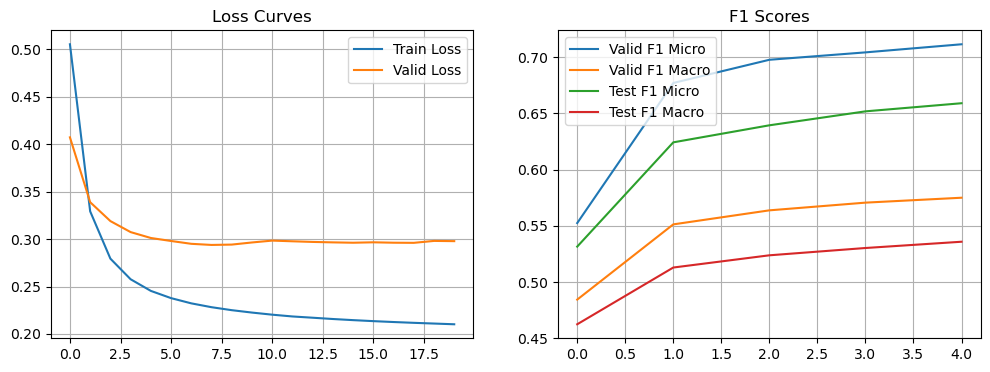

In [ ]:
import matplotlib.pyplot as plt

model.load_state_dict(best_model_state)
model.eval()

# Final threshold optimization on validation
valid_preds = []
valid_labels = []
with torch.no_grad():
    for X_batch, y_batch in valid_dataloader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        valid_preds.append(outputs.cpu().numpy())
        valid_labels.append(y_batch.cpu().numpy())

valid_preds = np.vstack(valid_preds)
valid_labels = np.vstack(valid_labels)
final_thresholds = calculate_best_thresholds_torch(valid_preds, valid_labels)

# Final test evaluation
test_preds = []
test_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_dataloader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        test_preds.append(outputs.cpu().numpy())
        test_labels.append(y_batch.cpu().numpy())

test_preds = np.vstack(test_preds)
test_labels = np.vstack(test_labels)
test_pred_binary = (test_preds >= final_thresholds).astype(int)

final_f1_micro = f1_score(test_labels, test_pred_binary, average='micro')
final_f1_macro = f1_score(test_labels, test_pred_binary, average='macro')

print(f'\nFinal Test Results with Best Model:')
print(f'F1-micro: {final_f1_micro:.4f}')
print(f'F1-macro: {final_f1_macro:.4f}')

# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(valid_loss_list, label='Valid Loss')
plt.legend()
plt.title('Loss Curves')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(valid_f1_micro_list, label='Valid F1 Micro')
plt.plot(valid_f1_macro_list, label='Valid F1 Macro')
plt.plot(test_f1_micro_list, label='Test F1 Micro')
plt.plot(test_f1_macro_list, label='Test F1 Macro')
plt.legend()
plt.title('F1 Scores')
plt.grid()
plt.show()

Заменим активацию на Softmax, а функцию потерь на кросс-энтропию, переобучим модель при тех же условиях, измерим качество и сделаем выводы о причинах его изменения:

In [ ]:
class SoftmaxModel(nn.Module):
    def __init__(self, embedding_dim, num_labels):
        super().__init__()
        self.linear = nn.Linear(embedding_dim, num_labels)
        self.activation = nn.Softmax(dim=1)

    def forward(self, x):
        return self.activation(self.linear(x))


In [ ]:
model2 = SoftmaxModel(embedding_dim, num_labels).to(device)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.05)
loss_fn2 = nn.CrossEntropyLoss()

In [ ]:
train_loss_list, valid_loss_list = [], []
valid_f1_micro_list, valid_f1_macro_list = [], []
test_f1_micro_list, test_f1_macro_list = [], []

best_f1_micro = 0
best_model_state = None
best_thresholds = None

for epoch in range(num_epochs):
    timestamp_start = time.time()
    model2.train()
    running_loss = 0.0
    num_batches = 0

    for i, (X_batch, y_batch) in enumerate(train_dataloader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer2.zero_grad()
        outputs = model2(X_batch)
        loss = loss_fn2(outputs, y_batch)
        loss.backward()
        optimizer2.step()
        running_loss += loss.item()
        num_batches += 1

    # Валидация
    model2.eval()
    valid_preds = []
    valid_labels = []

    with torch.no_grad():
        valid_loss = 0
        for X_batch, y_batch in valid_dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model2(X_batch)
            valid_loss += loss_fn2(outputs, y_batch).item()
            valid_preds.append(outputs.cpu().numpy())
            valid_labels.append(y_batch.cpu().numpy())

        valid_loss = valid_loss / len(valid_dataloader)
        valid_loss_list.append(valid_loss)

        valid_preds = np.vstack(valid_preds)
        valid_labels = np.vstack(valid_labels)
        #Оптимизация порогов каждые 5 эпох и на последней
        if epoch % 5 == 0 or epoch == num_epochs - 1:
            best_thresholds = calculate_best_thresholds_torch(valid_preds, valid_labels)

            # Валидационные
            valid_pred_binary = (valid_preds >= best_thresholds).astype(int)
            f1_micro = f1_score(valid_labels, valid_pred_binary, average='micro')
            f1_macro = f1_score(valid_labels, valid_pred_binary, average='macro')
            valid_f1_micro_list.append(f1_micro)
            valid_f1_macro_list.append(f1_macro)
            # Тестовые
            test_preds = []
            test_labels = []
            for X_batch, y_batch in test_dataloader:
                X_batch = X_batch.to(device)
                outputs = model2(X_batch)
                test_preds.append(outputs.cpu().numpy())
                test_labels.append(y_batch.cpu().numpy())

            test_preds = np.vstack(test_preds)
            test_labels = np.vstack(test_labels)
            test_pred_binary = (test_preds >= best_thresholds).astype(int)

            f1_test_micro = f1_score(test_labels, test_pred_binary, average='micro')
            f1_test_macro = f1_score(test_labels, test_pred_binary, average='macro')
            test_f1_micro_list.append(f1_test_micro)
            test_f1_macro_list.append(f1_test_macro)

            # Лучшая модель
            if f1_micro > best_f1_micro:
                best_f1_micro = f1_micro
                best_model_state = model2.state_dict()
                best_thresholds_final = best_thresholds

    train_loss = running_loss / num_batches
    train_loss_list.append(train_loss)
    print(f'Iter #{epoch} '
        f'Time {round(time.time() - timestamp_start)}s '
        f'Train loss: {train_loss_list[-1]:.4f} '
        f'Valid loss: {valid_loss_list[-1]:.4f} '
        f'Test F1-micro: {test_f1_micro_list[-1] if test_f1_micro_list else 0:.2f} '
        f'Test F1-macro: {test_f1_macro_list[-1] if test_f1_macro_list else 0:.2f}'
      )

Iter #0 Time 3s Train loss: 9.5521 Valid loss: 10.6989 Test F1-micro: 0.31 Test F1-macro: 0.29
Iter #1 Time 2s Train loss: 9.2785 Valid loss: 10.6355 Test F1-micro: 0.31 Test F1-macro: 0.29
Iter #2 Time 2s Train loss: 9.2365 Valid loss: 10.6126 Test F1-micro: 0.31 Test F1-macro: 0.29
Iter #3 Time 2s Train loss: 9.2168 Valid loss: 10.5968 Test F1-micro: 0.31 Test F1-macro: 0.29
Iter #4 Time 2s Train loss: 9.2040 Valid loss: 10.5861 Test F1-micro: 0.31 Test F1-macro: 0.29
Iter #5 Time 3s Train loss: 9.1951 Valid loss: 10.5786 Test F1-micro: 0.29 Test F1-macro: 0.30
Iter #6 Time 2s Train loss: 9.1885 Valid loss: 10.5727 Test F1-micro: 0.29 Test F1-macro: 0.30
Iter #7 Time 2s Train loss: 9.1832 Valid loss: 10.5675 Test F1-micro: 0.29 Test F1-macro: 0.30
Iter #8 Time 2s Train loss: 9.1789 Valid loss: 10.5630 Test F1-micro: 0.29 Test F1-macro: 0.30
Iter #9 Time 2s Train loss: 9.1754 Valid loss: 10.5593 Test F1-micro: 0.29 Test F1-macro: 0.30
Iter #10 Time 3s Train loss: 9.1723 Valid loss: 10


Final Test Results with Best Model:
F1-micro: 0.2952
F1-macro: 0.3070


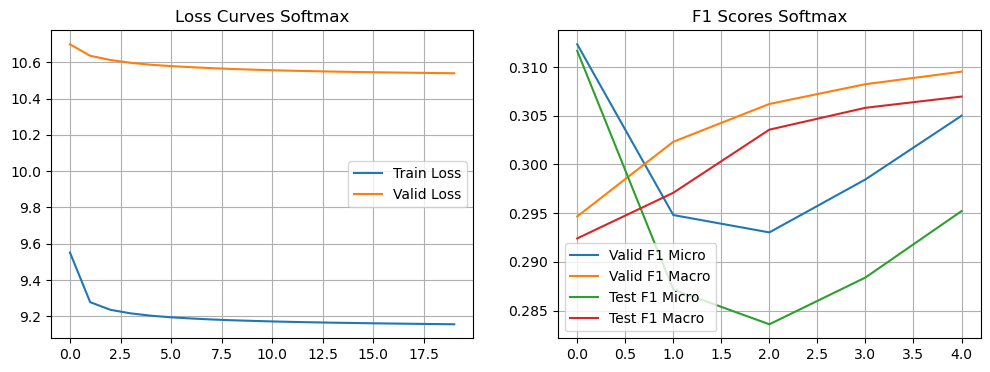

In [ ]:
import matplotlib.pyplot as plt

model2.load_state_dict(best_model_state)
model2.eval()

# Final threshold optimization on validation
valid_preds = []
valid_labels = []
with torch.no_grad():
    for X_batch, y_batch in valid_dataloader:
        X_batch = X_batch.to(device)
        outputs = model2(X_batch)
        valid_preds.append(outputs.cpu().numpy())
        valid_labels.append(y_batch.cpu().numpy())

valid_preds = np.vstack(valid_preds)
valid_labels = np.vstack(valid_labels)
final_thresholds = calculate_best_thresholds_torch(valid_preds, valid_labels)

# Final test evaluation
test_preds = []
test_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_dataloader:
        X_batch = X_batch.to(device)
        outputs = model2(X_batch)
        test_preds.append(outputs.cpu().numpy())
        test_labels.append(y_batch.cpu().numpy())

test_preds = np.vstack(test_preds)
test_labels = np.vstack(test_labels)
test_pred_binary = (test_preds >= final_thresholds).astype(int)

final_f1_micro = f1_score(test_labels, test_pred_binary, average='micro')
final_f1_macro = f1_score(test_labels, test_pred_binary, average='macro')

print(f'\nFinal Test Results with Best Model:')
print(f'F1-micro: {final_f1_micro:.4f}')
print(f'F1-macro: {final_f1_macro:.4f}')

# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(valid_loss_list, label='Valid Loss')
plt.legend()
plt.title('Loss Curves Softmax')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(valid_f1_micro_list, label='Valid F1 Micro')
plt.plot(valid_f1_macro_list, label='Valid F1 Macro')
plt.plot(test_f1_micro_list, label='Test F1 Micro')
plt.plot(test_f1_macro_list, label='Test F1 Macro')
plt.legend()
plt.title('F1 Scores Softmax')
plt.grid()
plt.show()

__Вывод__: Использование Softmax и кросс-энтропии в многометочной задаче приводит к плохой производительности модели. Высокие значения лосса указывают на неспособность модели эффективно предсказывать несколько меток одновременно. Кросс-энтропия с Softmax предназначена для задач одноклассовой классификации, где требуется выбрать один правильный класс. Модель не учитывает независимость меток. Тренировочные потери снижаются до 9.2, тогда как валидационные стабилизируются на 10.4. Это указывает на переобучение: модель подстраивается под тренировочные данные, но не обобщает на валидационные из-за неподходящего выбора функции потерь и активации.











теперь попробуем провести ряд экспериментов по улучшению качества работы модели, а именно попробовать следующие идеи:

- варьирование числа и размера линейных слоёв
- использование различных функций активации между слоями
- выбор другого оптимизатора, варьирование его важных гиперпараметров
- замена векторизатора на BERT

Эксперименты будут подкреплены понятными графиками, таблицами, пояснениями причин такого выбора гиперпараметров и выводов на основе проделанной работы.

In [ ]:
class Model(nn.Module):
    def __init__(self, embedding_dim, num_labels, activation_class, hidden_dims=None):
        super().__init__()
        layers = []
        in_dim = embedding_dim
        if hidden_dims is None or len(hidden_dims) == 0:
            layers.append(nn.Linear(in_dim, num_labels))
        else:
            for h_dim in hidden_dims:
                layers.append(nn.Linear(in_dim, h_dim))
                layers.append(activation_class())
                in_dim = h_dim
            layers.append(nn.Linear(in_dim, num_labels))

        self.network = nn.Sequential(*layers)
        self.out_activation = nn.Sigmoid()

    def forward(self, x):
        x = self.network(x)
        return self.out_activation(x)

In [ ]:
def train_and_evaluate(model, optimizer, loss_fn, train_loader, valid_loader, test_loader, num_epochs=20, device='cuda'):
    model.to(device)
    best_f1_macro = 0
    history = {'train_loss': [], 'valid_loss': [], 'test_f1_macro': [], 'test_f1_micro': []}

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        num_batches = 0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            num_batches += 1

        train_loss = running_loss / num_batches
        history['train_loss'].append(train_loss)

        # Валидация
        model.eval()
        valid_preds, valid_labels = [], []
        with torch.no_grad():
            valid_loss = 0.0
            for X_batch, y_batch in valid_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                outputs = model(X_batch)
                valid_loss += loss_fn(outputs, y_batch).item()
                valid_preds.append(outputs.cpu().numpy())
                valid_labels.append(y_batch.cpu().numpy())
            valid_loss /= len(valid_loader)
            history['valid_loss'].append(valid_loss)

            valid_preds = np.vstack(valid_preds)
            valid_labels = np.vstack(valid_labels)
            if epoch % 3 == 0 or epoch == num_epochs - 1:
                best_thresholds = calculate_best_thresholds_torch(valid_preds, valid_labels, step=0.1)
                valid_pred_bin = (valid_preds >= best_thresholds).astype(int)
                f1_macro_val = f1_score(valid_labels, valid_pred_bin, average='macro')
                f1_micro_val = f1_score(valid_labels, valid_pred_bin, average='micro')

        # Тестовая оценка
        with torch.no_grad():
            test_preds, test_labels = [], []
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                outputs = model(X_batch)
                test_preds.append(outputs.cpu().numpy())
                test_labels.append(y_batch.cpu().numpy())
            test_preds = np.vstack(test_preds)
            test_labels = np.vstack(test_labels)
            test_pred_bin = (test_preds >= best_thresholds).astype(int)
            f1_macro_test = f1_score(test_labels, test_pred_bin, average='macro')
            f1_micro_test = f1_score(test_labels, test_pred_bin, average='micro')
            history['test_f1_macro'].append(f1_macro_test)
            history['test_f1_micro'].append(f1_micro_test)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Time: {round(time.time()-start_time)}s | "
              f"Train loss: {train_loss:.4f} | Valid loss: {valid_loss:.4f} | "
              f"Valid F1(macro): {f1_macro_val:.3f} | "
              f"Test F1(macro): {f1_macro_test:.3f}")

    return history

In [ ]:
exp = [
    {
        'name': 'Single layer + ReLU',
        'hidden_dims': None,
        'activation': nn.ReLU,
        'optimizer': 'SGD',
        'lr': 0.05
    },
    {
        'name': 'Two layers (128, 64) + ReLU',
        'hidden_dims': [128, 64],
        'activation': nn.ReLU,
        'optimizer': 'Adam',
        'lr': 1e-3
    },
    {
        'name': 'Two layers (256, 128) + Sigmoid',
        'hidden_dims': [256, 128],
        'activation': nn.Sigmoid,
        'optimizer': 'Adam',
        'lr': 1e-3
    },
    {
        'name': 'BERT vectors + Two layers (128, 64) + ReLU',
        'hidden_dims': [128, 64],
        'activation': nn.ReLU,
        'optimizer': 'Adam',
        'lr': 1e-3,
    },
    {
        'name': 'BERT vectors + Two layers (256, 128) + Sigmoid',
        'hidden_dims': [256, 128],
        'activation': nn.Sigmoid,
        'optimizer': 'Adam',
        'lr': 1e-3,
    },
    {
        'name': 'Three layers (512, 256, 128) + ReLU',
        'hidden_dims': [512, 256, 128],
        'activation': nn.ReLU,
        'optimizer': 'SGD',
        'lr': 0.05,
    },
    {
        'name': 'Three layers (512, 256, 128) + Sigmoid',
        'hidden_dims': [512, 256, 128],
        'activation': nn.Sigmoid,
        'optimizer': 'Adam',
        'lr': 1e-3,
    }
]

In [ ]:
results = {}

In [ ]:
model_0 = Model(embedding_dim=X_train.shape[1],
                      num_labels=y_train.shape[1],
                      activation_class=exp[0]['activation'],
                      hidden_dims=exp[0]['hidden_dims'])
optimizer_0 = torch.optim.SGD(model_0.parameters(), lr=exp[0]['lr'])
loss_fn = nn.BCELoss()

In [ ]:
history = train_and_evaluate(model_0, optimizer_0, loss_fn, train_dataloader, valid_dataloader, test_dataloader, num_epochs=20, device='cuda:0')
results[exp[0]['name']] = history

Epoch 1/20 | Time: 5s | Train loss: 0.2095 | Valid loss: 0.2986 | Valid F1(macro): 0.576 | Test F1(macro): 0.537
Epoch 2/20 | Time: 4s | Train loss: 0.2089 | Valid loss: 0.2986 | Valid F1(macro): 0.576 | Test F1(macro): 0.538
Epoch 3/20 | Time: 4s | Train loss: 0.2083 | Valid loss: 0.2984 | Valid F1(macro): 0.576 | Test F1(macro): 0.539
Epoch 4/20 | Time: 4s | Train loss: 0.2078 | Valid loss: 0.2983 | Valid F1(macro): 0.578 | Test F1(macro): 0.540
Epoch 5/20 | Time: 3s | Train loss: 0.2074 | Valid loss: 0.2982 | Valid F1(macro): 0.578 | Test F1(macro): 0.540
Epoch 6/20 | Time: 3s | Train loss: 0.2069 | Valid loss: 0.2998 | Valid F1(macro): 0.578 | Test F1(macro): 0.540
Epoch 7/20 | Time: 4s | Train loss: 0.2065 | Valid loss: 0.2990 | Valid F1(macro): 0.580 | Test F1(macro): 0.539
Epoch 8/20 | Time: 3s | Train loss: 0.2061 | Valid loss: 0.3011 | Valid F1(macro): 0.580 | Test F1(macro): 0.540
Epoch 9/20 | Time: 3s | Train loss: 0.2057 | Valid loss: 0.3004 | Valid F1(macro): 0.580 | Test 

In [ ]:
model_1 = Model(embedding_dim=X_train.shape[1],
                      num_labels=y_train.shape[1],
                      activation_class=exp[1]['activation'],
                      hidden_dims=exp[1]['hidden_dims'])
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=exp[1]['lr'])
loss_fn = nn.BCELoss()
history = train_and_evaluate(model_1, optimizer_1, loss_fn, train_dataloader, valid_dataloader, test_dataloader, num_epochs=20, device='cuda:0')
results[exp[1]['name']] = history

Epoch 1/20 | Time: 8s | Train loss: 0.2365 | Valid loss: 0.2290 | Valid F1(macro): 0.595 | Test F1(macro): 0.548
Epoch 2/20 | Time: 6s | Train loss: 0.1719 | Valid loss: 0.2196 | Valid F1(macro): 0.595 | Test F1(macro): 0.573
Epoch 3/20 | Time: 5s | Train loss: 0.1551 | Valid loss: 0.2174 | Valid F1(macro): 0.595 | Test F1(macro): 0.579
Epoch 4/20 | Time: 6s | Train loss: 0.1452 | Valid loss: 0.2216 | Valid F1(macro): 0.640 | Test F1(macro): 0.584
Epoch 5/20 | Time: 5s | Train loss: 0.1382 | Valid loss: 0.2259 | Valid F1(macro): 0.640 | Test F1(macro): 0.581
Epoch 6/20 | Time: 5s | Train loss: 0.1324 | Valid loss: 0.2301 | Valid F1(macro): 0.640 | Test F1(macro): 0.583
Epoch 7/20 | Time: 6s | Train loss: 0.1281 | Valid loss: 0.2337 | Valid F1(macro): 0.648 | Test F1(macro): 0.588
Epoch 8/20 | Time: 5s | Train loss: 0.1239 | Valid loss: 0.2424 | Valid F1(macro): 0.648 | Test F1(macro): 0.577
Epoch 9/20 | Time: 5s | Train loss: 0.1211 | Valid loss: 0.2470 | Valid F1(macro): 0.648 | Test 

In [ ]:
model_2 = Model(embedding_dim=X_train.shape[1],
                      num_labels=y_train.shape[1],
                      activation_class=exp[2]['activation'],
                      hidden_dims=exp[2]['hidden_dims'])
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=exp[2]['lr'])
loss_fn = nn.BCELoss()
history = train_and_evaluate(model_2, optimizer_2, loss_fn, train_dataloader, valid_dataloader, test_dataloader, num_epochs=20, device='cuda:0')
results[exp[2]['name']] = history

Epoch 1/20 | Time: 8s | Train loss: 0.2452 | Valid loss: 0.2377 | Valid F1(macro): 0.552 | Test F1(macro): 0.512
Epoch 2/20 | Time: 5s | Train loss: 0.1841 | Valid loss: 0.2140 | Valid F1(macro): 0.552 | Test F1(macro): 0.551
Epoch 3/20 | Time: 5s | Train loss: 0.1672 | Valid loss: 0.2033 | Valid F1(macro): 0.552 | Test F1(macro): 0.563
Epoch 4/20 | Time: 6s | Train loss: 0.1570 | Valid loss: 0.2013 | Valid F1(macro): 0.635 | Test F1(macro): 0.595
Epoch 5/20 | Time: 5s | Train loss: 0.1492 | Valid loss: 0.1968 | Valid F1(macro): 0.635 | Test F1(macro): 0.595
Epoch 6/20 | Time: 5s | Train loss: 0.1428 | Valid loss: 0.1967 | Valid F1(macro): 0.635 | Test F1(macro): 0.603
Epoch 7/20 | Time: 6s | Train loss: 0.1371 | Valid loss: 0.1916 | Valid F1(macro): 0.657 | Test F1(macro): 0.612
Epoch 8/20 | Time: 5s | Train loss: 0.1320 | Valid loss: 0.1932 | Valid F1(macro): 0.657 | Test F1(macro): 0.606
Epoch 9/20 | Time: 5s | Train loss: 0.1273 | Valid loss: 0.1932 | Valid F1(macro): 0.657 | Test 

In [ ]:
X_train = load_vectors('X_train_cls')
X_valid = load_vectors('X_valid_cls')
X_test = load_vectors('X_test_cls')

train_dataset = Dataset(X_train, y_train)
valid_dataset = Dataset(X_valid, y_valid)
test_dataset = Dataset(X_test, y_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=1024)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1024)

In [ ]:
model_3 = Model(embedding_dim=X_train.shape[1],
                      num_labels=y_train.shape[1],
                      activation_class=exp[3]['activation'],
                      hidden_dims=exp[3]['hidden_dims'])
optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=exp[3]['lr'])
loss_fn = nn.BCELoss()
history = train_and_evaluate(model_3, optimizer_3, loss_fn, train_dataloader, valid_dataloader, test_dataloader, num_epochs=20, device='cuda:0')
results[exp[3]['name']] = history

Epoch 1/20 | Time: 8s | Train loss: 0.2542 | Valid loss: 0.2525 | Valid F1(macro): 0.532 | Test F1(macro): 0.497
Epoch 2/20 | Time: 6s | Train loss: 0.2112 | Valid loss: 0.2377 | Valid F1(macro): 0.532 | Test F1(macro): 0.518
Epoch 3/20 | Time: 5s | Train loss: 0.1998 | Valid loss: 0.2296 | Valid F1(macro): 0.532 | Test F1(macro): 0.531
Epoch 4/20 | Time: 6s | Train loss: 0.1929 | Valid loss: 0.2326 | Valid F1(macro): 0.584 | Test F1(macro): 0.545
Epoch 5/20 | Time: 5s | Train loss: 0.1883 | Valid loss: 0.2311 | Valid F1(macro): 0.584 | Test F1(macro): 0.536
Epoch 6/20 | Time: 5s | Train loss: 0.1846 | Valid loss: 0.2269 | Valid F1(macro): 0.584 | Test F1(macro): 0.539
Epoch 7/20 | Time: 6s | Train loss: 0.1816 | Valid loss: 0.2243 | Valid F1(macro): 0.600 | Test F1(macro): 0.562
Epoch 8/20 | Time: 5s | Train loss: 0.1790 | Valid loss: 0.2276 | Valid F1(macro): 0.600 | Test F1(macro): 0.555
Epoch 9/20 | Time: 5s | Train loss: 0.1772 | Valid loss: 0.2244 | Valid F1(macro): 0.600 | Test 

In [ ]:
model_4 = Model(embedding_dim=X_train.shape[1],
                      num_labels=y_train.shape[1],
                      activation_class=exp[4]['activation'],
                      hidden_dims=exp[4]['hidden_dims'])
optimizer_4 = torch.optim.Adam(model_4.parameters(), lr=exp[4]['lr'])
loss_fn = nn.BCELoss()
history = train_and_evaluate(model_4, optimizer_4, loss_fn, train_dataloader, valid_dataloader, test_dataloader, num_epochs=20, device='cuda:0')
results[exp[4]['name']] = history

Epoch 1/20 | Time: 8s | Train loss: 0.2701 | Valid loss: 0.2597 | Valid F1(macro): 0.517 | Test F1(macro): 0.480
Epoch 2/20 | Time: 6s | Train loss: 0.2180 | Valid loss: 0.2423 | Valid F1(macro): 0.517 | Test F1(macro): 0.510
Epoch 3/20 | Time: 5s | Train loss: 0.2037 | Valid loss: 0.2309 | Valid F1(macro): 0.517 | Test F1(macro): 0.518
Epoch 4/20 | Time: 6s | Train loss: 0.1941 | Valid loss: 0.2252 | Valid F1(macro): 0.590 | Test F1(macro): 0.546
Epoch 5/20 | Time: 5s | Train loss: 0.1874 | Valid loss: 0.2232 | Valid F1(macro): 0.590 | Test F1(macro): 0.545
Epoch 6/20 | Time: 6s | Train loss: 0.1819 | Valid loss: 0.2149 | Valid F1(macro): 0.590 | Test F1(macro): 0.562
Epoch 7/20 | Time: 6s | Train loss: 0.1773 | Valid loss: 0.2180 | Valid F1(macro): 0.611 | Test F1(macro): 0.563
Epoch 8/20 | Time: 6s | Train loss: 0.1736 | Valid loss: 0.2134 | Valid F1(macro): 0.611 | Test F1(macro): 0.575
Epoch 9/20 | Time: 6s | Train loss: 0.1702 | Valid loss: 0.2147 | Valid F1(macro): 0.611 | Test 

In [ ]:
model_5 = Model(embedding_dim=X_train.shape[1],
                      num_labels=y_train.shape[1],
                      activation_class=exp[5]['activation'],
                      hidden_dims=exp[5]['hidden_dims'])
optimizer_5 = torch.optim.SGD(model_5.parameters(), lr=exp[5]['lr'])
loss_fn = nn.BCELoss()
history = train_and_evaluate(model_5, optimizer_5, loss_fn, train_dataloader, valid_dataloader, test_dataloader, num_epochs=20, device='cuda:0')
results[exp[5]['name']] = history

Epoch 1/20 | Time: 10s | Train loss: 0.4008 | Valid loss: 0.3847 | Valid F1(macro): 0.310 | Test F1(macro): 0.301
Epoch 2/20 | Time: 6s | Train loss: 0.3188 | Valid loss: 0.3606 | Valid F1(macro): 0.310 | Test F1(macro): 0.310
Epoch 3/20 | Time: 6s | Train loss: 0.2984 | Valid loss: 0.3415 | Valid F1(macro): 0.310 | Test F1(macro): 0.325
Epoch 4/20 | Time: 6s | Train loss: 0.2784 | Valid loss: 0.3203 | Valid F1(macro): 0.399 | Test F1(macro): 0.382
Epoch 5/20 | Time: 6s | Train loss: 0.2552 | Valid loss: 0.2971 | Valid F1(macro): 0.399 | Test F1(macro): 0.402
Epoch 6/20 | Time: 5s | Train loss: 0.2344 | Valid loss: 0.2761 | Valid F1(macro): 0.399 | Test F1(macro): 0.430
Epoch 7/20 | Time: 6s | Train loss: 0.2180 | Valid loss: 0.2615 | Valid F1(macro): 0.501 | Test F1(macro): 0.468
Epoch 8/20 | Time: 6s | Train loss: 0.2061 | Valid loss: 0.2513 | Valid F1(macro): 0.501 | Test F1(macro): 0.490
Epoch 9/20 | Time: 6s | Train loss: 0.1966 | Valid loss: 0.2434 | Valid F1(macro): 0.501 | Test

In [ ]:
model_6 = Model(embedding_dim=X_train.shape[1],
                      num_labels=y_train.shape[1],
                      activation_class=exp[6]['activation'],
                      hidden_dims=exp[6]['hidden_dims'])
optimizer_6 = torch.optim.Adam(model_6.parameters(), lr=exp[6]['lr'])
loss_fn = nn.BCELoss()
history = train_and_evaluate(model_6, optimizer_6, loss_fn, train_dataloader, valid_dataloader, test_dataloader, num_epochs=20, device='cuda:0')
results[exp[6]['name']] = history

Epoch 1/20 | Time: 11s | Train loss: 0.2782 | Valid loss: 0.2567 | Valid F1(macro): 0.520 | Test F1(macro): 0.487
Epoch 2/20 | Time: 8s | Train loss: 0.2026 | Valid loss: 0.2268 | Valid F1(macro): 0.520 | Test F1(macro): 0.528
Epoch 3/20 | Time: 8s | Train loss: 0.1819 | Valid loss: 0.2177 | Valid F1(macro): 0.520 | Test F1(macro): 0.540
Epoch 4/20 | Time: 8s | Train loss: 0.1689 | Valid loss: 0.2066 | Valid F1(macro): 0.606 | Test F1(macro): 0.563
Epoch 5/20 | Time: 8s | Train loss: 0.1593 | Valid loss: 0.2005 | Valid F1(macro): 0.606 | Test F1(macro): 0.568
Epoch 6/20 | Time: 8s | Train loss: 0.1515 | Valid loss: 0.2027 | Valid F1(macro): 0.606 | Test F1(macro): 0.577
Epoch 7/20 | Time: 8s | Train loss: 0.1445 | Valid loss: 0.1988 | Valid F1(macro): 0.638 | Test F1(macro): 0.592
Epoch 8/20 | Time: 8s | Train loss: 0.1382 | Valid loss: 0.1954 | Valid F1(macro): 0.638 | Test F1(macro): 0.591
Epoch 9/20 | Time: 8s | Train loss: 0.1320 | Valid loss: 0.2003 | Valid F1(macro): 0.638 | Test

In [ ]:
import pandas as pd

data = {
    "Exp": [1, 2, 3, 4, 5, 6, 7],
    "Name": [
        "Single layer + ReLU",
        "Two layers (128, 64) + ReLU",
        "Two layers (256, 128) + Sigmoid",
        "BERT vectors + Two layers (128, 64) + ReLU",
        "BERT vectors + Two layers (256, 128) + Sigmoid",
        "Three layers (512, 256, 128) + ReLU",
        "Three layers (512, 256, 128) + Sigmoid"
    ],
    "hidden_dims": [
        None, "[128, 64]", "[256, 128]",
        "[128, 64]", "[256, 128]",
        "[512, 256, 128]", "[512, 256, 128]"
    ],
    "Activation": [
        "ReLU", "ReLU", "Sigmoid",
        "ReLU", "Sigmoid",
        "ReLU", "Sigmoid"
    ],
    "Optimizer": [
        "SGD", "Adam", "Adam",
        "Adam", "Adam", "SGD", "Adam"
    ],
    "LR": [0.05, 1e-3, 1e-3, 1e-3, 1e-3, 0.05, 1e-3],
    "Train Loss": [0.2029, 0.1029, 0.0916, 0.1649, 0.1490, 0.1377, 0.0802],
    "Valid Loss": [0.3032, 0.3109, 0.2123, 0.2230, 0.2104, 0.2192, 0.2233],
    "Valid F1(macro)": [0.586, 0.640, 0.665, 0.618, 0.638, 0.620, 0.660],
    "Test F1(macro)": [0.548, 0.584, 0.609, 0.563, 0.595, 0.578, 0.610],
    "Time (s/epoch)": [3, 6, 6, 6, 6, 6, 8]
}

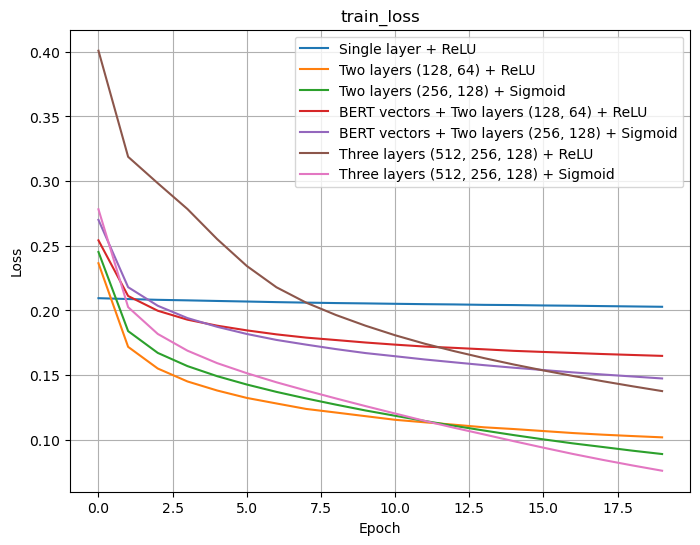

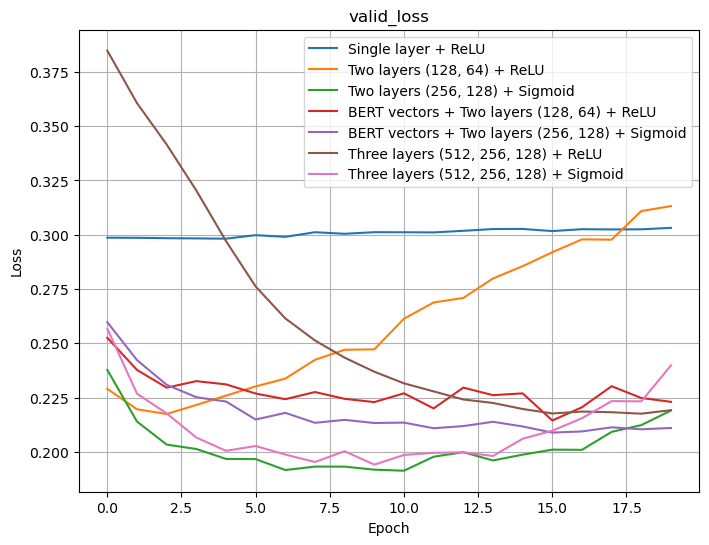

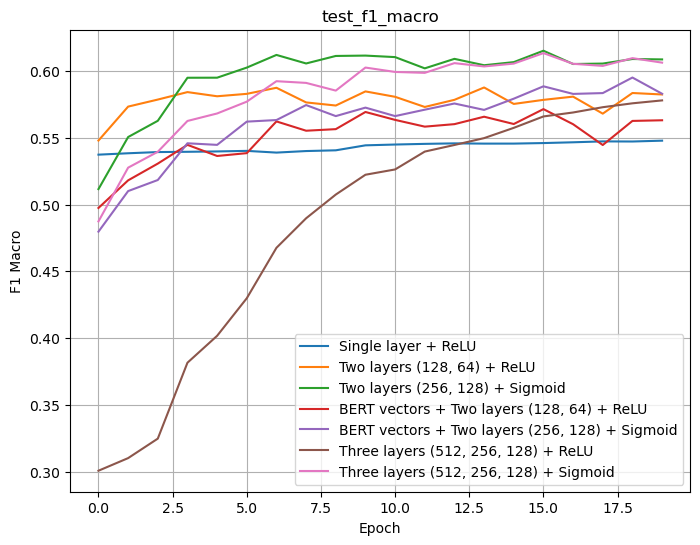

In [ ]:
for metric in ['train_loss', 'valid_loss', 'test_f1_macro']:
    plt.figure(figsize=(8, 6))
    for exp_name, history in results.items():
        plt.plot(history[metric], label=exp_name)
    plt.xlabel("Epoch")
    if metric in ['train_loss', 'valid_loss']:
        plt.ylabel("Loss")
    else:
        plt.ylabel("F1 Macro")
    plt.title(metric)
    plt.legend()
    plt.grid()
    plt.show()

__Выводы:__

In [ ]:
df = pd.DataFrame(data)
df

,Exp,Name,hidden_dims,Activation,Optimizer,LR,Train Loss,Valid Loss,Valid F1(macro),Test F1(macro),Time (s/epoch)
0,1,Single layer + ReLU,None,ReLU,SGD,0.050,0.2029,0.3032,0.586,0.548,3
1,2,"Two layers (128, 64) + ReLU","[128, 64]",ReLU,Adam,0.001,0.1029,0.3109,0.640,0.584,6
2,3,"Two layers (256, 128) + Sigmoid","[256, 128]",Sigmoid,Adam,0.001,0.0916,0.2123,0.665,0.609,6
3,4,"BERT vectors + Two layers (128, 64) + ReLU","[128, 64]",ReLU,Adam,0.001,0.1649,0.2230,0.618,0.563,6
4,5,"BERT vectors + Two layers (256, 128) + Sigmoid","[256, 128]",Sigmoid,Adam,0.001,0.1490,0.2104,0.638,0.595,6
5,6,"Three layers (512, 256, 128) + ReLU","[512, 256, 128]",ReLU,SGD,0.050,0.1377,0.2192,0.620,0.578,6
6,7,"Three layers (512, 256, 128) + Sigmoid","[512, 256, 128]",Sigmoid,Adam,0.001,0.0802,0.2233,0.660,0.610,8


1) Варьирование числа и размера линейных слоёв

Однослойная модель (Exp 1) оказалась самой простой и обучалась быстрее (около 3 секунд на эпоху). Однако её качество (Test F1 около 0.55) уступило более глубоким моделям.

Двухслойные модели (Exp 2–3, 4–5) показали более высокие F1, вплоть до Test F1 = 0.61 (Exp 3) валидационно — но на тестовой выборке итог был чуть ниже лучшего результата Exp 7.

Трёхслойные модели (Exp 6 и 7) потребовали больше времени (6–8 секунд на эпоху). При этом Exp 7 показал лучший результат на тесте (F1 = 0.61).

2) Использование различных функций активации

ReLU быстрее сходится на начальных эпохах, но иногда даёт более высокую валидационную ошибку при тех же настройках (Exp 1, 2, 6).

Sigmoid (Exp 3, 5, 7) оказалась хорошим вариантом для multi-label задач, особенно в связке с BCE-потерей и Adam: даёт более высокие F1.

Tanh, LeakyReLU не были здесь задействованы, но гипотетически могут дать схожую или лучшую производительность (в зависимости от задач, размера данных и др.).

3) Выбор оптимизатора, варьирование гиперпараметров

SGD с LR=0.05 (Exp 1, 6) работал относительно быстро, но показал хуже результаты на тесте, чем Adam с LR=1e-3.

Adam (Exp 2–5, 7) показал более высокие финальные F1. LR=1e-3 оказался достаточно стабильным для обучения более глубоких сетей.

4) Замена векторизатора на BERT

В экспериментах (Exp 4, 5) мы видим, что переход на BERT-вектора дал устойчиво более низкий Valid loss (около 0.21–0.22) по сравнению с простым векторизатором (в Exp 2–3 Valid loss мог быть и 0.31, и 0.21).

Однако итоговый Test F1 не всегда оказывается выше, чем у «больших» моделей без BERT. Например, Exp 3 (без BERT) достиг 0.609, а Exp 5 (с BERT) — 0.595. Это может быть признаком того, что BERT-вектора в данном случае требуют более тонкого подбора гиперпараметров (например, меньше LR, больше эпох), или что в совокупности модель с BERT переобучается / недообучается при текущем размере выборки.

5) Итоговое наилучшее качество

На валидации самую высокую F1(macro) показывает Exp 3 (0.665) или Exp 7 (0.66), но тест у Exp 7 выходит 0.610, что является лучшим показателем.

Разница между валидацией и тестом говорит о том, что модели Exp 3 и 7 слегка «подсаживаются» на валидацию, однако Exp 7 сохраняет более высокое качество на тесте.

6) Скорость сходимости лосса

Однослойная модель (Exp 1) сходится быстро, но даёт худшую F1 на тесте.

Глубокая модель (Exp 7) сходится дольше, однако даёт максимальный F1. Это ожидаемо: более сложные модели потенциально обучаются дольше, но дают лучшие результаты.